In [125]:
import cv2
import numpy as np
import pandas as pd
import os
from os.path import basename, join
import glob
from matplotlib import pyplot as plt
import time
from sklearn.model_selection import train_test_split

from tensorflow import keras
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D
from keras.layers import MaxPooling3D
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical

import datetime
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [172]:
cap = cv2.VideoCapture('train/apple/apple-2.mp4')

tmp_frames = []

while cap.isOpened():

    # Read feed
    ret, frame = cap.read()
    if not ret:
        break


    tmp_frames.append(resize_frame(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))

cap.release()
cv2.destroyAllWindows()

tmp_frames = frame_select(tmp_frames)

In [173]:
len(tmp_frames)

20

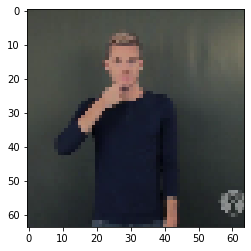

In [174]:
plt.imshow(tmp_frames[10])

In [176]:
tmp_test = np.array(tmp_frames)
tmp_test.shape

(20, 64, 64, 3)

In [155]:
def resize_frame(img):
    size = img.shape[0]
    start = int((img.shape[1]-img.shape[0])/2)
    new_img = img[:,start:start+size,:]
    new_img = cv2.resize(new_img, (64, 64))
    return new_img

In [156]:
def get_lists(folder):
    name_list = []
    path_list = []
    label = []
    num = 0
    for i in glob.glob(join(folder, '*')):
        name_list.append(basename(i))
        for j in glob.glob(join(i, '*.mp4')):
            path_list.append(j)
            label.append(num)
        num = num+1
    return name_list, path_list, label

In [157]:
def frame_select(frames):
    result_frames = []
    for i in range(20):
        index = (i+1)*int(len(frames)/21)
        result_frames.append(frames[index])
    return result_frames

In [195]:
def frame_select_ex(frames, number):
    result_frames = []
    for i in range(10):
        index = (i+1)*int(len(frames)/11) + int(number)
        result_frames.append(frames[index])
    return result_frames

In [196]:
def collect_data(path_list):
    collect_df = []
    
    for tmp_path in path_list:
        cap = cv2.VideoCapture(tmp_path)
        tmp_df = []

        while cap.isOpened():

            # Read feed
            ret, frame = cap.read()
            if not ret:
                break

            
            tmp_df.append(resize_frame(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))

        cap.release()
        cv2.destroyAllWindows()
        
        tmp_df = frame_select(tmp_df)
        collect_df.append(tmp_df)
        
    return collect_df

In [197]:
def collect_data_ex(path_list, label):
    collect_df = []
    new_label = []
    
    i = 0
    for tmp_path in path_list:
        cap = cv2.VideoCapture(tmp_path)
        tmp_df = []

        while cap.isOpened():

            # Read feed
            ret, frame = cap.read()
            if not ret:
                break

            
            tmp_df.append(resize_frame(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)))

        cap.release()
        cv2.destroyAllWindows()
        
        for j in range(9):
            tmp_df = frame_select_ex(tmp_df, j)
            collect_df.append(tmp_df)
            
            new_label.append(label[i])
        
        i = i+1
        
    return collect_df, new_label

In [159]:
name_list, path_list, label = get_lists('self_data/')

In [160]:
len(name_list)

5

In [161]:
len(path_list)

107

In [162]:
df = collect_data(path_list)

In [163]:
X = np.array(df)/225
X.shape

(107, 20, 64, 64, 3)

In [164]:
y = np.array(label)
y.shape

(107,)

In [165]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [166]:
y_test.shape

(11,)

## ex dataset:

In [198]:
name_list, path_list, label = get_lists('train/')

In [199]:
len(name_list)

11

In [200]:
df_ex, label_ex = collect_data_ex(path_list, label)

In [201]:
X = np.array(df_ex)
X.shape

(531, 10, 64, 64, 3)

In [202]:
y = np.array(label_ex)
y.shape

(531,)

In [203]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [204]:
y_test.shape

(54,)

## ex End

In [121]:
model = keras.Sequential([
    TimeDistributed(Conv2D(32, (3, 3), padding="same", activation="relu"), input_shape = X.shape[1:]),
    TimeDistributed(MaxPooling2D(pool_size=(2, 2))),
#     Dropout(0.2),
    TimeDistributed(Conv2D(64, (3, 3), padding="same", activation="relu")),
    TimeDistributed(MaxPooling2D(pool_size=(2, 2))),
#     Dropout(0.2),
    TimeDistributed(Conv2D(128, (3, 3), padding="same", activation="relu")),
    TimeDistributed(MaxPooling2D(pool_size=(2, 2))),
    
    TimeDistributed(Flatten()),
    
    LSTM(128, return_sequences=True, activation='relu'),
    LSTM(64, return_sequences=True, activation='relu'),
    LSTM(32, return_sequences=False, activation='relu'),
    
#     Dense(32, activation="relu"),
#     Dropout(0.2),
    Dense(len(name_list), activation="softmax"),
])

# optimizer = keras.optimizers.Adam(learning_rate=0.0003)
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [122]:
history = model.fit(X_train, y_train, epochs=100, batch_size = 32)

Epoch 1/100
2/2 [==============================] - 6s 2s/step - loss: 2.3986 - accuracy: 0.1094
Epoch 2/100
2/2 [==============================] - 3s 2s/step - loss: 2.3955 - accuracy: 0.1250
Epoch 3/100
2/2 [==============================] - 3s 2s/step - loss: 2.3917 - accuracy: 0.0781
Epoch 4/100
2/2 [==============================] - 3s 2s/step - loss: 2.3845 - accuracy: 0.1719
Epoch 5/100
2/2 [==============================] - 4s 2s/step - loss: 2.3711 - accuracy: 0.2344
Epoch 6/100
2/2 [==============================] - 3s 1s/step - loss: 2.3684 - accuracy: 0.1406
Epoch 7/100
2/2 [==============================] - 3s 1s/step - loss: 2.3132 - accuracy: 0.1406
Epoch 8/100
2/2 [==============================] - 3s 1s/step - loss: 2.3410 - accuracy: 0.2031
Epoch 9/100
2/2 [==============================] - 3s 1s/step - loss: 2.2740 - accuracy: 0.2188
Epoch 10/100
2/2 [==============================] - 3s 1s/step - loss: 2.3368 - accuracy: 0.1250
Epoch 11/100
2/2 [=====================

2/2 [==============================] - 3s 2s/step - loss: 1.1950 - accuracy: 0.6250
Epoch 86/100
2/2 [==============================] - 3s 2s/step - loss: 1.2093 - accuracy: 0.6094
Epoch 87/100
2/2 [==============================] - 3s 2s/step - loss: 1.0889 - accuracy: 0.6875
Epoch 88/100
2/2 [==============================] - 3s 1s/step - loss: 0.9725 - accuracy: 0.6719
Epoch 89/100
2/2 [==============================] - 3s 2s/step - loss: 0.8556 - accuracy: 0.6719
Epoch 90/100
2/2 [==============================] - 3s 1s/step - loss: 0.8159 - accuracy: 0.7188
Epoch 91/100
2/2 [==============================] - 3s 1s/step - loss: 0.8834 - accuracy: 0.7812
Epoch 92/100
2/2 [==============================] - 3s 1s/step - loss: 0.9037 - accuracy: 0.6719
Epoch 93/100
2/2 [==============================] - 3s 1s/step - loss: 1.1296 - accuracy: 0.6406
Epoch 94/100
2/2 [==============================] - 3s 2s/step - loss: 2.4126 - accuracy: 0.5625
Epoch 95/100
2/2 [=========================

In [123]:
results = model.evaluate(X_test, y_test)
print('test acuracy:',results[1])

1/1 [==============================] - 1s 712ms/step - loss: 3.2476 - accuracy: 0.1250
test acuracy: 0.125


In [208]:
model2 = keras.Sequential([
    ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = X.shape[1:]), 
    MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'),
    TimeDistributed(Dropout(0.2)), 
    ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True), 
    MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'), 
    TimeDistributed(Dropout(0.2)), 
    ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True), 
    MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'), 
    TimeDistributed(Dropout(0.2)), 
    ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True), 
    MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'), 
    Flatten(), 
    Dense(len(name_list), activation = "softmax"),
])

model2.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_20 (ConvLSTM2D)  (None, 10, 62, 62, 4)    1024      
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 10, 31, 31, 4)    0         
 g3D)                                                            
                                                                 
 time_distributed_70 (TimeDi  (None, 10, 31, 31, 4)    0         
 stributed)                                                      
                                                                 
 conv_lstm2d_21 (ConvLSTM2D)  (None, 10, 29, 29, 8)    3488      
                                                                 
 max_pooling3d_21 (MaxPoolin  (None, 10, 15, 15, 8)    0         
 g3D)                                                            
                                                     

In [209]:
model2.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model2.fit(X_train, y_train, epochs = 10, batch_size = 4, shuffle = True, validation_split = 0.2)

Epoch 1/10
96/96 [==============================] - 44s 389ms/step - loss: 2.3564 - accuracy: 0.1680 - val_loss: 2.2301 - val_accuracy: 0.2188
Epoch 2/10
96/96 [==============================] - 39s 402ms/step - loss: 1.9113 - accuracy: 0.3570 - val_loss: 1.6376 - val_accuracy: 0.4375
Epoch 3/10
96/96 [==============================] - 38s 398ms/step - loss: 1.6272 - accuracy: 0.4488 - val_loss: 1.7407 - val_accuracy: 0.5417
Epoch 4/10
96/96 [==============================] - 37s 385ms/step - loss: 1.3762 - accuracy: 0.5328 - val_loss: 1.0696 - val_accuracy: 0.6042
Epoch 5/10
96/96 [==============================] - 38s 393ms/step - loss: 1.0590 - accuracy: 0.6299 - val_loss: 0.7657 - val_accuracy: 0.6875
Epoch 6/10
96/96 [==============================] - 37s 390ms/step - loss: 0.7794 - accuracy: 0.7638 - val_loss: 0.7731 - val_accuracy: 0.7083
Epoch 7/10
96/96 [==============================] - 38s 398ms/step - loss: 0.7104 - accuracy: 0.7769 - val_loss: 0.6004 - val_accuracy: 0.7812

In [210]:
model2.evaluate(X_test, y_test)

2/2 [==============================] - 1s 278ms/step - loss: 0.2192 - accuracy: 0.9259


[0.2192440778017044, 0.9259259104728699]

In [211]:
model2.evaluate(X_train, y_train)

15/15 [==============================] - 6s 389ms/step - loss: 0.2238 - accuracy: 0.9329


[0.2238004058599472, 0.9329140186309814]

In [212]:
for i in range(len(y_test)):
    print(name_list[y_test[i]])

black
black
cold
bird
black
ball
ball
apple
baby
cold
cold
ball
baby
ball
drink
apple
bad
cold
cold
black
bad
bad
cold
big
baby
bird
apple
black
black
bad
cold
big
black
ball
apple
bad
baby
apple
big
bad
drink
big
cold
coffee
coffee
big
cold
baby
ball
bad
cold
baby
ball
bad


In [180]:
tmp_test = tmp_test.reshape(1, 20, 64, 64, 3)

In [183]:
result = model2.predict(tmp_test)

In [184]:
print(name_list[np.argmax(result)])

big
